## Imagery layers and Raster analysis

In [48]:
import arcgis


### Access Landsat imagery

In [19]:
from arcgis.gis import GIS

In [20]:
gis = GIS(profile='pythonapi')

In [21]:
landsat_item = gis.content.search('title: Multispectral Landsat',
                                  'Imagery Layer', outside_org=True) [0]

In [121]:
landsat_item.layers

[<ImageryLayer url:"https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer">]

### View Landsat imagery layer item description

In [23]:
from IPython.display import HTML
HTML(landsat_item.description)

Band Num.


### Access the layers available with the Landsat Imagery Layer item

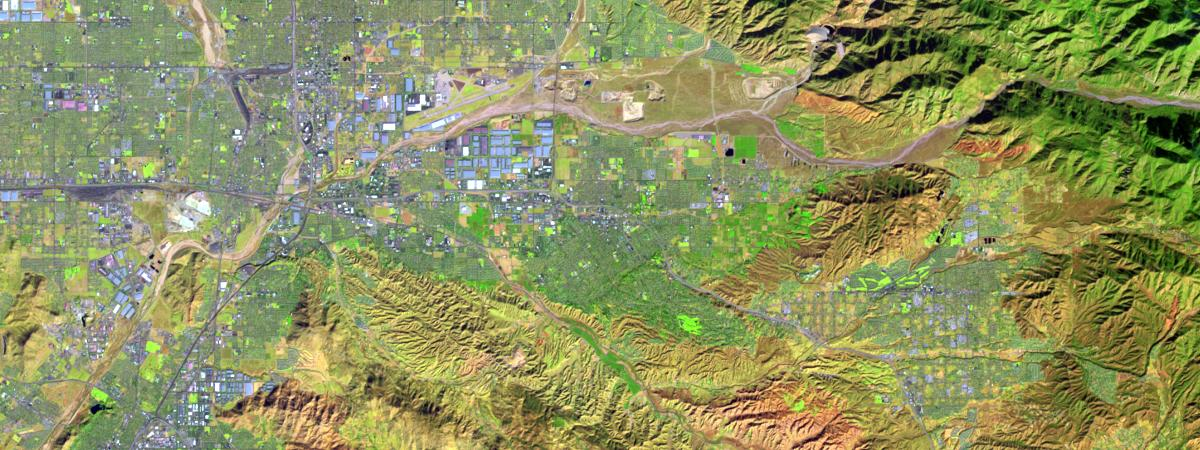

In [137]:
landsat = landsat_item.layers[0]
landsat 

In [138]:
landsat.url 'https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer'

'https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer'

## Explore different wavelength bands

In [25]:
import pandas as pd

In [26]:
pd.DataFrame(landsat.key_properties()['BandProperties'])

,BandIndex,BandName,DatasetTag,WavelengthMax,WavelengthMin
0,0,CoastalAerosol,MS,450,430
1,1,Blue,MS,510,450
2,2,Green,MS,590,530
3,3,Red,MS,670,640
4,4,NearInfrared,MS,880,850
5,5,ShortWaveInfrared_1,MS,1650,1570
6,6,ShortWaveInfrared_2,MS,2290,2110
7,7,Cirrus,MS,1380,1360


## Visualize the layer in the map widget

In [131]:
m = gis.map('Redlands, CA')
m

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

In [132]:
m.add_layer(landsat)

In [134]:
import time
from arcgis.raster.functions import apply

for rasterfunc in landsat.properties.rasterFunctionInfos:
    print (rasterfunc.name)
    m.add_layer(apply(landsat, rasterfunc.name))
    time.sleep(2)

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Geology with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Agriculture
Bathymetric
Color Infrared
Geology
Natural Color
Short-wave Infrared
NDVI Colorized
Normalized Difference Moisture Index Colorized
NDVI Raw
NBR Raw
None


### Interactive raster processing in Jupyter Notebook

In [30]:
color_infrared = apply(landsat, 'Color Infrared with DRA')

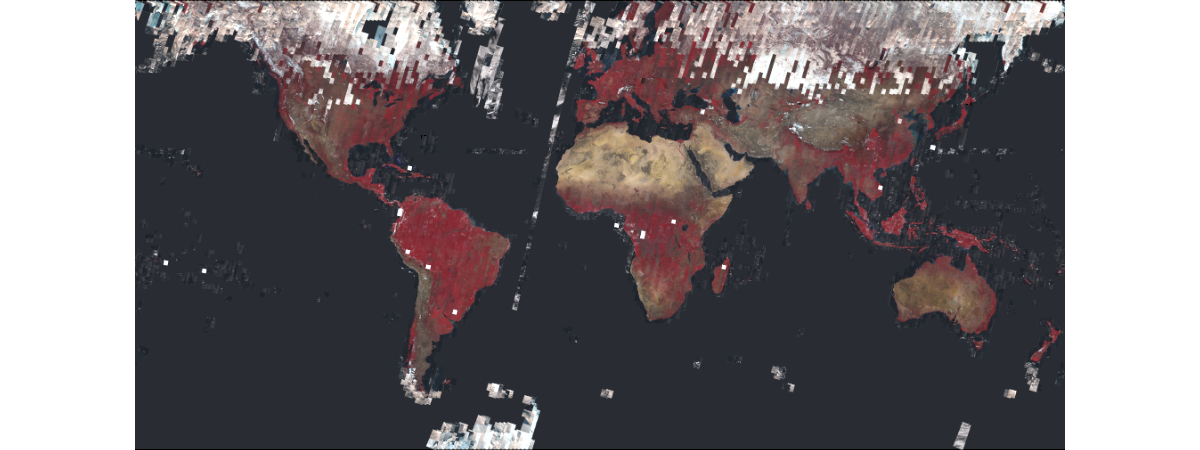

In [31]:
color_infrared 

In [32]:
m = gis.map('Redlands, CA')
m.add_layer(color_infrared)
m

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

### Setting an area of interest

In [33]:
from arcgis.geocoding import geocode
area = geocode('Redlands, CA', out_sr=landsat.properties.spatialReference)[0]

In [34]:
color_infrared.extent = area['extent']

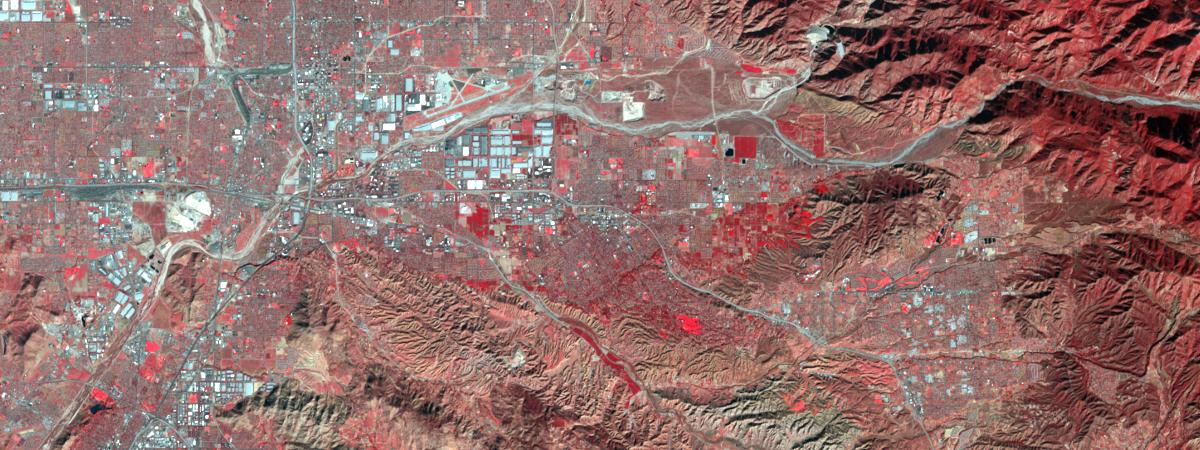

In [35]:
color_infrared

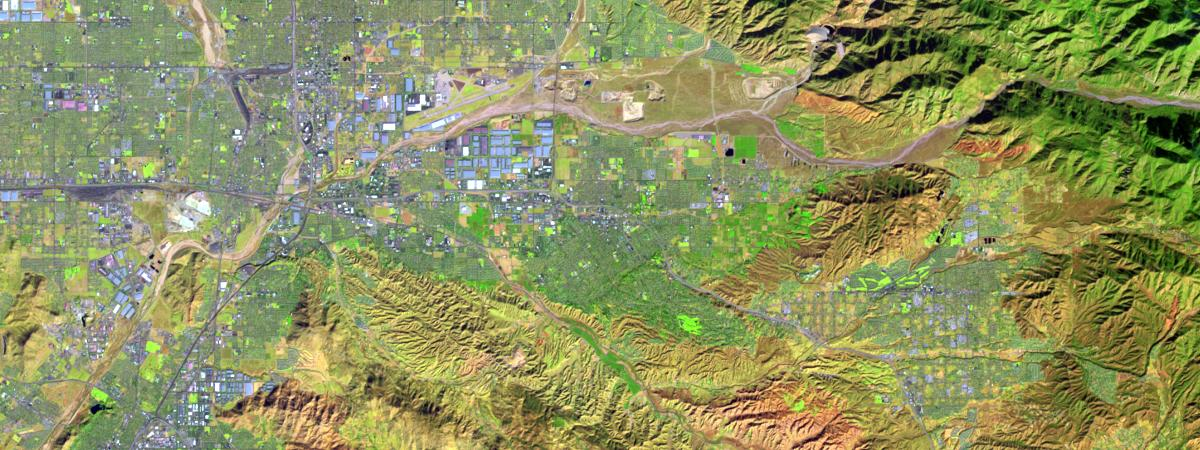

In [36]:
landsat.extent = area['extent']
landsat

## Exporting Images from Imagery Layer

In [37]:
from IPython.display import Image

In [38]:
img = landsat.export_image(bbox=area['extent'], size=[1200,450], f='image')

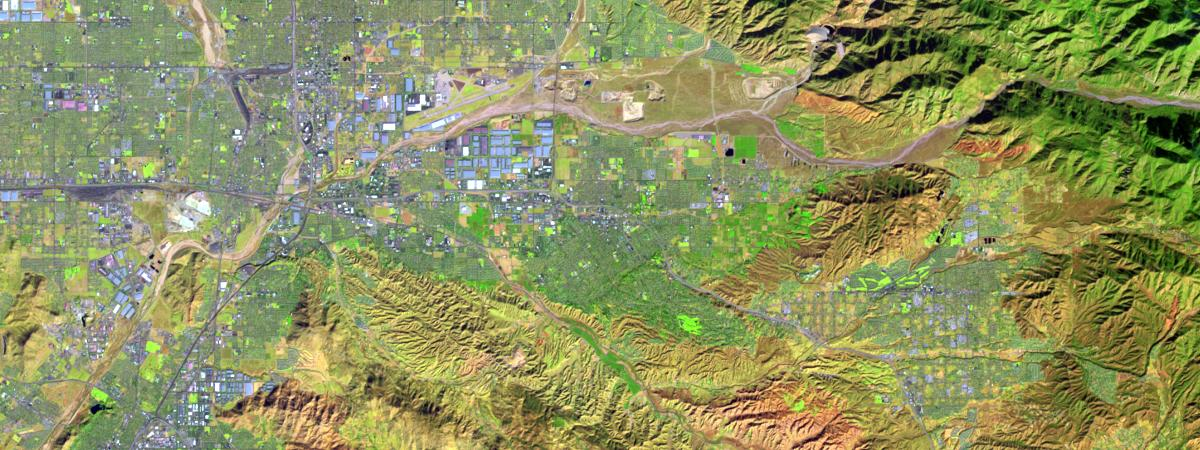

In [39]:
Image(img)

In [40]:
savedimg = landsat.export_image(bbox=area['extent'], size=[1200,450], 
                                f='image', save_folder='.', 
                                save_file='img.jpg')

In [41]:
savedimg

'.\\img.jpg'

In [42]:
from IPython.display import Image

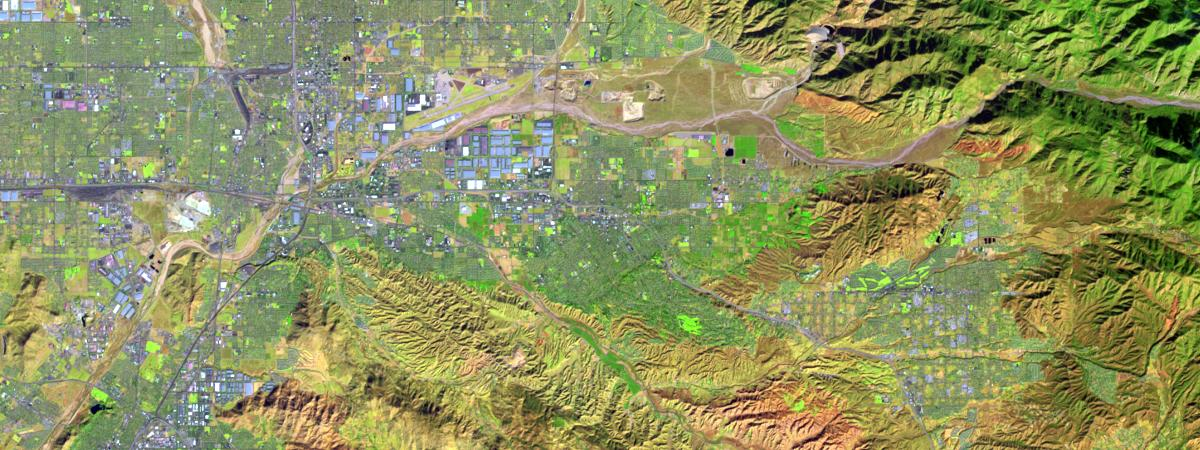

In [43]:
Image(filename=savedimg, width=1200, height=450)

### Exporting images with raster function applied to them

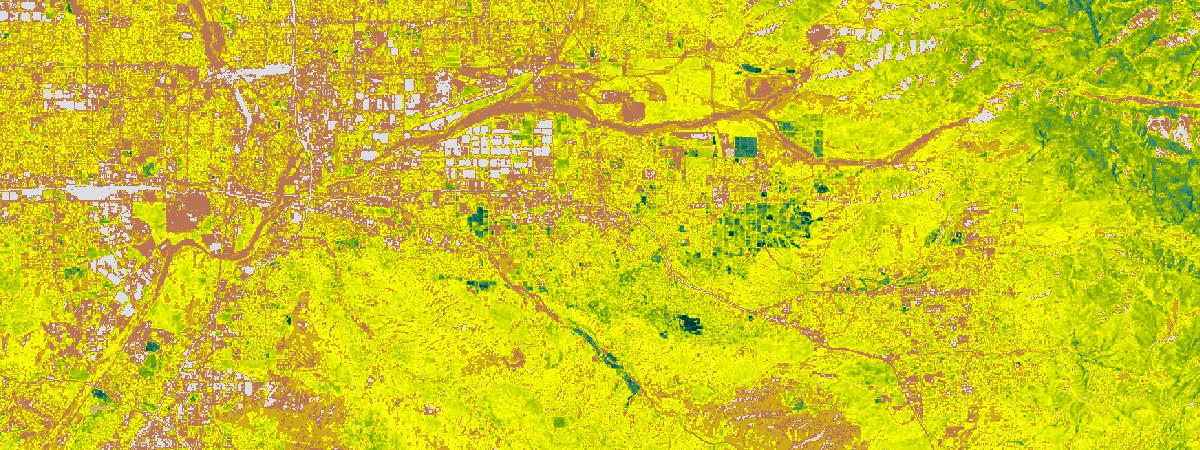

In [44]:
ndvi_colorized = apply(landsat, 'NDVI Colorized')
ndvi_colorized

## Extracting custom bands

In [45]:
from arcgis.raster.functions import stretch, extract_band

In [46]:
naturalcolor = stretch(extract_band(landsat, [3,2,1]), 
                    stretch_type='percentclip', min_percent=0.1, max_percent=0.1, 
                       gamma=[1, 1, 1], dra=True)

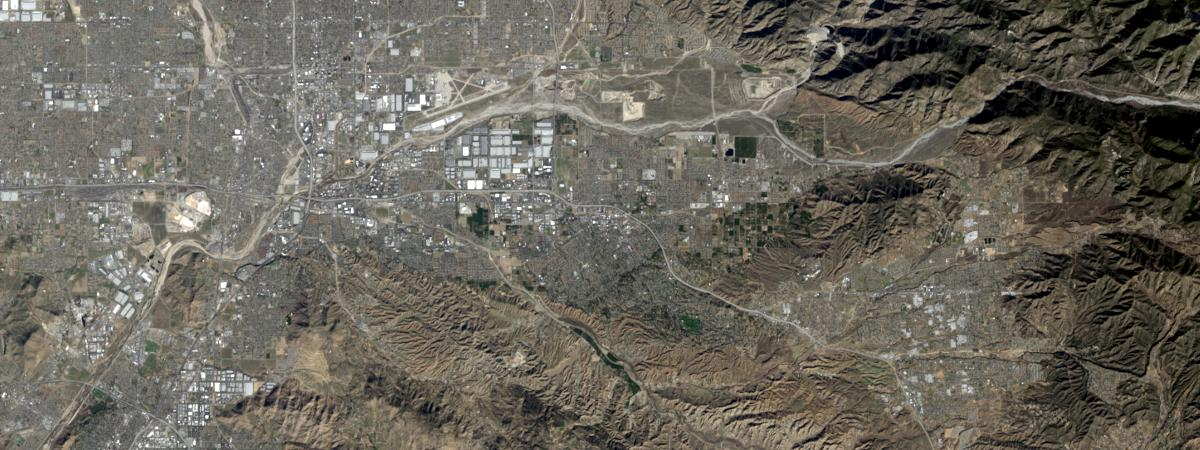

In [47]:
naturalcolor

# Clipping to an area of interest

In [76]:
from arcgis.geometry import Geometry, buffer 

In [77]:
poly = buffer(geometries=[Geometry(area['location'])],
              in_sr=102100, distances=6000, unit='esriMeters')[0]

In [115]:
from  arcgis.geoenrichment import Country
usa = Country.get('US')
redlands = usa.subgeographies.states['California'].zip5['92373']

In [78]:
from arcgis.raster.functions import clip

In [116]:
redclip = clip(landsat, redlands.geometry)

In [117]:
m = gis.map('Redlands, CA')

In [118]:
m 

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

In [119]:
m.add_layer(redclip)

## Select images by where clause, geometry and time range

In [83]:
selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.10) AND (WRS_Row = 36)", 
                   geometry=arcgis.geometry.filters.intersects(area['extent']))

In [84]:
fs = selected.query(out_fields="AcquisitionDate, GroupName, Best, CloudCover, WRS_Row, Month, Name", 
              return_geometry=True,
              return_distinct_values=False,
              order_by_fields="AcquisitionDate")

In [85]:
df = fs.df
df.head()

,AcquisitionDate,Best,CloudCover,GroupName,Month,Name,OBJECTID,Shape_Area,Shape_Length,WRS_Row,SHAPE
0,233798400000,95957036,-0.01,p043r036_2x19770530,5,p043r036_2dm19770530_z11_MS,680821,5.026523e+10,897574.641900,36,"{'rings': [[[-12889114.8652, 4207339.365500003..."
1,642038400000,91960036,-0.01,p040r036_5x19900507,5,p040r036_5dt19900507_z11_MS,672866,4.694317e+10,867257.252743,36,"{'rings': [[[-12902153.7239, 4064989.857699997..."
2,956534400000,88960036,0.00,p040r036_7x20000424,4,p040r036_7dt20000424_z11_MS,663606,4.600983e+10,858608.456217,36,"{'rings': [[[-12872961.873599999, 4197538.7916..."
3,1116892800000,79960036,0.00,L7040036_03620050524,5,L72040036_03620050524_MS,654645,4.766887e+10,874086.578684,36,"{'rings': [[[-12867140.4332, 4198647.7443], [-..."
4,1242000000000,72960036,0.00,L5040036_03620090511,5,L5040036_03620090511_MS,642745,4.781355e+10,875674.823359,36,"{'rings': [[[-12862615.619800001, 4191651.0291..."


Looking at the shape of the dataframe we see that 46 scenes match the specified criteria:

In [86]:
df.shape

(60, 11)

The footprints of the rasters matching the criteria can be drawn using the map widget:

In [114]:
df['Time'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df['Time'].tail(10)

50   2017-09-06 18:22:15.910
51   2017-09-22 18:22:19.809
52   2017-10-08 18:22:25.538
53   2017-10-24 18:22:27.513
54   2017-11-09 18:22:25.639
55   2017-11-25 18:22:19.854
56   2017-12-27 18:22:19.819
57   2018-01-12 18:22:13.604
58   2018-01-28 18:22:04.379
59   2018-03-01 18:21:51.174
Name: Time, dtype: datetime64[ns]

### Resolving overlapping pixels in selected rasters

In [88]:
m = gis.map('Redlands, CA', 7)
display(m)
m.add_layer(selected.last())

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[34.05538000000007, -117.18258999999995], zoom=7)

In [89]:
m = gis.map('Redlands, CA', 7)
display(m)
m.add_layer(selected.first())

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[34.05538000000007, -117.18258999999995], zoom=7)

# Change Detection

In [90]:
old = landsat.filter_by('OBJECTID=1139')

In [91]:
new = landsat.filter_by('OBJECTID=463490')

## Difference Image

Difference Image mode illustrates all the changes in NDVI (vegeration index) between the two dates:

increases are shown in green, and decreases are shown in magenta. 

In [92]:
from arcgis.raster.functions import *

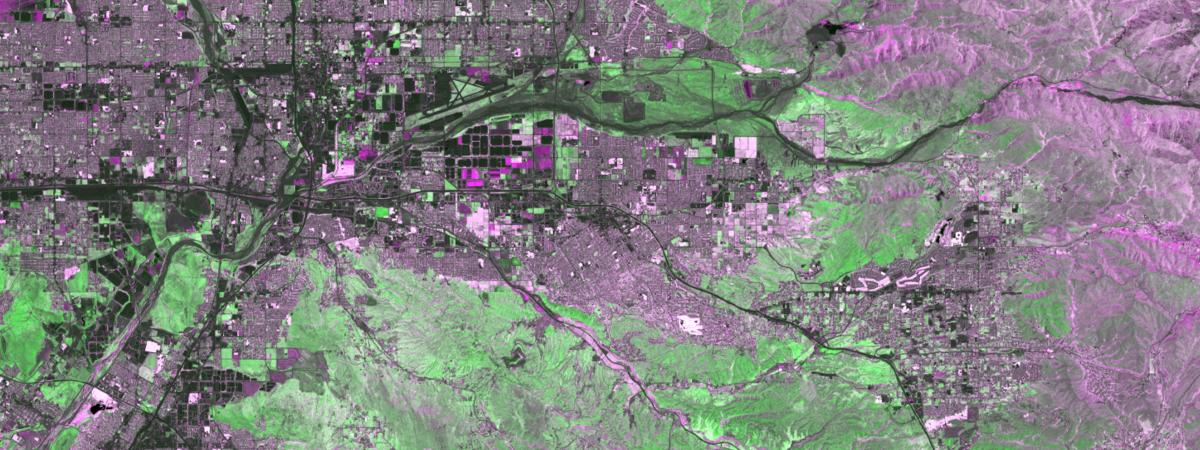

In [93]:
diff = stretch(composite_band([ndvi(old, '5 4'),
                               ndvi(new, '5 4'),
                               ndvi(old, '5 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, 
               max=255, dra=True, astype='u8')
diff

### Applying a threshold mask

The difference can also be computed using map algebra, as shown below:

In [94]:
ndvi_diff = ndvi(new, '5 4') - ndvi(old, '5 4')

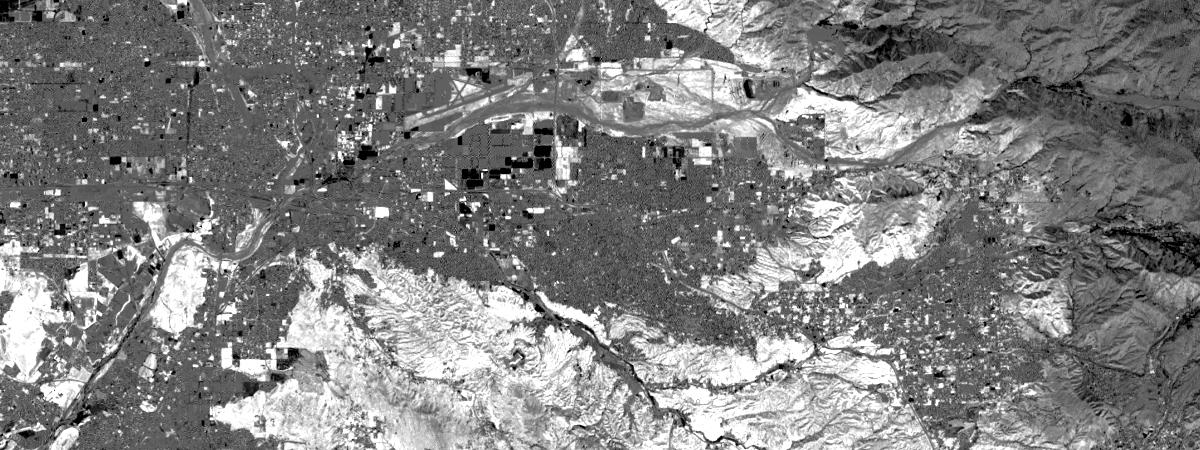

In [95]:
ndvi_diff

However, in the image above is hard to visualize in which areas the vegetation index changed by a specified threshold. The example below renders the areas where the change is above the specified threshold and renders it using a green color:

In [96]:
threshold_val = 0.1

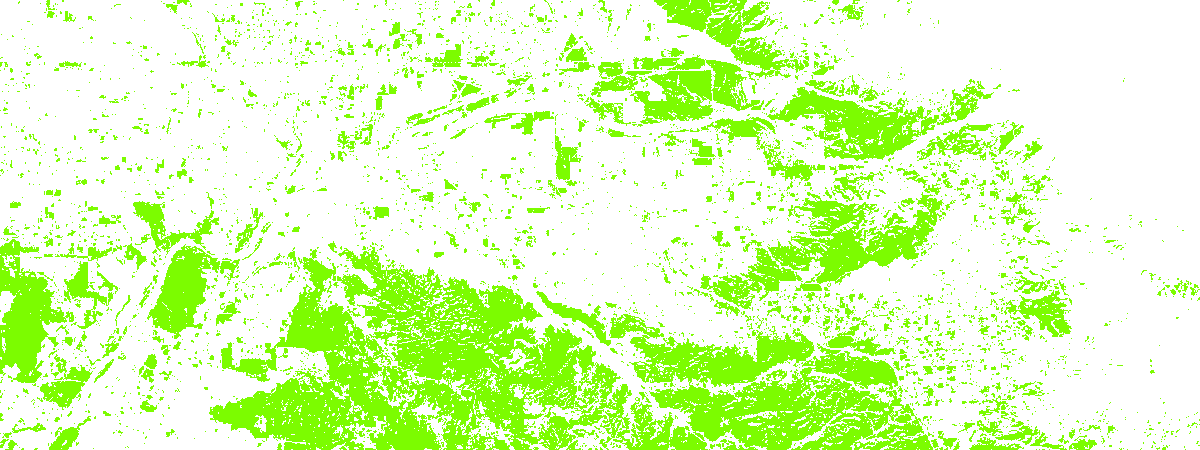

In [97]:
masked = colormap(remap(ndvi_diff, 
                        input_ranges=[threshold_val, 1], 
                        output_values=[1], 
                        no_data_ranges=[-1, threshold_val], astype='u8'), 
                  colormap=[[1, 124, 252, 0]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

## Visualize ndvi change

In [110]:
tm = gis.map('Redlands, CA')
tm

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

In [111]:
tm.add_layer(diff)

In [135]:
tm.add_layer(masked) 

In [136]:
masked.url

'https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer'

### Persisting your analysis for visualizaion or analysis